In [1]:
import os
os.chdir('../../')

In [2]:
!nvidia-smi

Sun Mar 30 10:53:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
| 32%   47C    P3             67W /  450W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### from "sample pair.ipynb"

In [3]:
import torch
import torch.nn.functional as F

total_samples = 256
save_file = f'/data/optimization/euler_NFE=1000_N={total_samples}_imagenet64.pt'
pairs = torch.load(save_file)
noise = pairs[:, 0]
target = pairs[:, 1]
print(noise.shape, target.shape)

torch.Size([256, 3, 64, 64]) torch.Size([256, 3, 64, 64])


In [4]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "100",
    "--skip_type", "logSNR",
    "--ni",

    "--sample_type", "rbfsolverglq10grad",
    "--timesteps", "5",
    "--log_scale_min", "-6.0",
    "--log_scale_max", "6.0",
    "--log_scale_num", "100",
    "--scale_dir", "/data/data/rbfsolverglq10grad",
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device


2025-03-30 10:53:30.527616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743299610.543074   18355 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743299610.547560   18355 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 10:53:30.562960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO - main.py - 2025-03-30 10:53:32,238 - Using device: cuda


[prepare_model] Model is ready.


In [5]:
!mkdir /data/data/rbfsolverglq10grad
!ls /data/data/rbfsolverglq10grad

mkdir: cannot create directory ‘/data/data/rbfsolverglq10grad’: File exists
'NFE=10,p=100,dataset=IMAGENET64.npy'  'NFE=25,p=100,dataset=IMAGENET64.npy'
'NFE=15,p=100,dataset=IMAGENET64.npy'  'NFE=5,p=100,dataset=IMAGENET64.npy'
'NFE=20,p=100,dataset=IMAGENET64.npy'


In [6]:
n = 256
noise_batch = noise[:n].to(device)
target_batch = target[:n].to(device)
print(noise_batch.shape)
(pred, optimal_gammas), _ = diffusion.sample_image(noise_batch, diffusion.model, classifier=diffusion.classifier, target=target_batch)
loss = F.mse_loss(pred, target_batch)
print('loss :', loss)
print(optimal_gammas)


torch.Size([256, 3, 64, 64])
/data/data/rbfsolverglq10grad/NFE=5,p=100,dataset=IMAGENET64.npy  saved!
loss : tensor(0.0471, device='cuda:0')
[[ 0.          0.40070388  2.94799304  0.82568771  1.25268126]
 [-0.70770204 -0.17267732 -0.16064583  0.16357973  0.        ]]


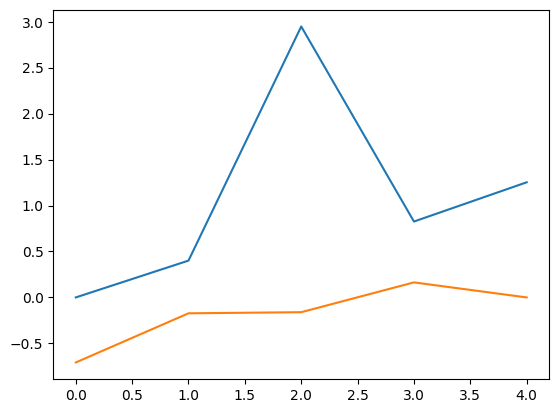

In [7]:
plt.plot(optimal_gammas[0])
plt.plot(optimal_gammas[1])
plt.show()

### Batch

In [3]:
import sys
import torch
import numpy as np
import random

from main import parse_args_and_config, Diffusion
from tqdm import tqdm
import torch.nn.functional as F

total_samples = 256
save_file = f'/data/optimization/euler_NFE=1000_N={total_samples}_imagenet64.pt'
pairs = torch.load(save_file)
noise = pairs[:, 0]
target = pairs[:, 1]
print(noise.shape, target.shape)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

for NFE in tqdm([5, 10, 20]):
    ###############################################################################
    # 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
    ###############################################################################
    sys.argv = [
        "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "100",
    "--skip_type", "logSNR",
    "--ni",

    "--sample_type", "rbfsolverglq10grad",
    "--timesteps", str(NFE),
    "--log_scale_min", "-6.0",
    "--log_scale_max", "6.0",
    "--log_scale_num", "100",
    "--scale_dir", "/data/data/rbfsolverglq10grad",
    ]

    ###############################################################################
    # 2) 인자/설정 로드
    ###############################################################################
    args, config = parse_args_and_config()

    ###############################################################################
    # 3) Diffusion 객체 생성 -> 모델 로딩
    ###############################################################################
    diffusion = Diffusion(args, config, rank=0)
    diffusion.prepare_model()
    diffusion.model.eval()

    ###############################################################################
    # 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
    ###############################################################################
    device = diffusion.device

    n = 256
    noise_batch = noise[:n].to(device)
    target_batch = target[:n].to(device)
    (pred, optimal_gammas), _ = diffusion.sample_image(noise_batch, diffusion.model, classifier=diffusion.classifier, target=target_batch)
    print(F.mse_loss(pred, target_batch))
    print(optimal_gammas)


2025-03-30 10:12:30.711551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743297150.727048   15058 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743297150.731731   15058 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 10:12:30.747603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


torch.Size([256, 3, 64, 64]) torch.Size([256, 3, 64, 64])


  0%|          | 0/3 [00:00<?, ?it/s]INFO - main.py - 2025-03-30 10:12:33,866 - Using device: cuda


[prepare_model] Model is ready.


 33%|███▎      | 1/3 [00:15<00:30, 15.29s/it]INFO - main.py - 2025-03-30 10:12:49,113 - Using device: cuda
INFO - main.py - 2025-03-30 10:12:49,113 - Using device: cuda


/data/data/rbfsolverglq10grad/NFE=5,p=100,dataset=IMAGENET64.npy  saved!
tensor(0.0471, device='cuda:0')
[[ 0.          0.40070388  2.94799304  0.82568771  1.25268126]
 [-0.70770204 -0.17267732 -0.16064583  0.16357973  0.        ]]
[prepare_model] Model is ready.


 33%|███▎      | 1/3 [00:26<00:52, 26.24s/it]


_LinAlgError: torch.linalg.solve: The solver failed because the input matrix is singular.